In [46]:
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf 
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score


In [ ]:
dataset_path = "./Combined_dataset" # adjust path


<h2> loading guitar chords and validating for files with no signals

In [6]:
import os, librosa, numpy as np

def is_invalid_audio(file_path, sr=22050, duration=2, offset=0.5):
    """
    Cek apakah audio rusak/kosong dengan cara mem‐load sebagian kecil.
    """
    try:
        signal, _ = librosa.load(file_path, sr=sr, duration=duration, offset=offset)
        return signal is None or len(signal) == 0 or np.all(signal == 0)
    except Exception as e:
        print(f"Error loading {file_path}: {e.__class__.__name__} - {e}")
        return True 

labels      = []   # label chord yang valid
total_sec   = 0.0  # akumulator durasi
n_valid_wav = 0    # penghitung file valid

for chord_quality_dir in os.listdir(dataset_path):
    chord_quality_path = os.path.join(dataset_path, chord_quality_dir)
    if os.path.isdir(chord_quality_path):
        for chord_label_dir in os.listdir(chord_quality_path):
            chord_label_path = os.path.join(chord_quality_path, chord_label_dir)
            if os.path.isdir(chord_label_path):
                for filename in os.listdir(chord_label_path):
                    if filename.lower().endswith(".wav"):
                        file_path = os.path.join(chord_label_path, filename)

                        if is_invalid_audio(file_path):
                            # hapus file yang rusak / kosong
                            try:
                                os.remove(file_path)
                                print(f"Deleted invalid file: {file_path}")
                            except Exception as e:
                                print(f"Failed to delete {file_path}: {e}")
                        else:
                            # ------ file valid ------
                            labels.append(chord_label_dir)

                            # gunakan get_duration → cepat (header-only)
                            try:
                                dur = librosa.get_duration(path=file_path)
                                total_sec   += dur
                                n_valid_wav += 1
                            except Exception as e:
                                print(f"Failed to read duration for {file_path}: {e}")

# ------ hasil ------
print("Label valid:", labels)

if n_valid_wav:
    avg_dur = total_sec / n_valid_wav
    print(f"Rata-rata durasi {n_valid_wav} file valid: {avg_dur:.2f} detik")
else:
    print("Tidak ada file .wav valid yang tersisa.")

Label valid: ['A#maj', 'A#maj', 'A#maj', 'A#maj', 'A#maj', 'A#maj', 'A#maj', 'A#maj', 'A#maj', 'A#maj', 'A#maj', 'A#maj', 'A#maj', 'A#maj', 'A#maj', 'A#maj', 'A#maj', 'A#maj', 'A#maj', 'A#maj', 'A#maj', 'A#maj', 'A#maj', 'A#maj', 'A#maj', 'A#maj', 'A#maj', 'A#maj', 'A#maj', 'A#maj', 'A#maj', 'A#maj', 'A#maj', 'A#maj', 'A#maj', 'A#maj', 'A#maj', 'A#maj', 'Amaj', 'Amaj', 'Amaj', 'Amaj', 'Amaj', 'Amaj', 'Amaj', 'Amaj', 'Amaj', 'Amaj', 'Amaj', 'Amaj', 'Amaj', 'Amaj', 'Amaj', 'Amaj', 'Amaj', 'Amaj', 'Amaj', 'Amaj', 'Amaj', 'Amaj', 'Amaj', 'Amaj', 'Amaj', 'Amaj', 'Amaj', 'Amaj', 'Amaj', 'Amaj', 'Amaj', 'Amaj', 'Bmaj', 'Bmaj', 'Bmaj', 'Bmaj', 'Bmaj', 'Bmaj', 'Bmaj', 'Bmaj', 'Bmaj', 'Bmaj', 'Bmaj', 'Bmaj', 'Bmaj', 'Bmaj', 'Bmaj', 'Bmaj', 'Bmaj', 'Bmaj', 'Bmaj', 'Bmaj', 'Bmaj', 'Bmaj', 'Bmaj', 'Bmaj', 'Bmaj', 'Bmaj', 'Bmaj', 'Bmaj', 'Bmaj', 'Bmaj', 'Bmaj', 'Bmaj', 'Bmaj', 'C#maj', 'C#maj', 'C#maj', 'C#maj', 'C#maj', 'C#maj', 'C#maj', 'C#maj', 'C#maj', 'C#maj', 'C#maj', 'C#maj', 'C#maj', 'C#maj'

In [7]:
print(len(labels))

1785


In [8]:
label_quality_count = {
    "major7": 0,
    "major":  0,
    "minor7": 0,
    "minor":  0
}
for label in labels:
    label = label.lower()
    if label.endswith("maj7"):
        label_quality_count["major7"] += 1
    elif label.endswith("maj"):
        label_quality_count["major"]  += 1
    elif label.endswith("min7"):
        label_quality_count["minor7"] += 1
    elif label.endswith("min"):
        label_quality_count["minor"]  += 1
    else :
        print(f"Error found in {label}")
print(label_quality_count)

{'major7': 505, 'major': 415, 'minor7': 553, 'minor': 312}


In [13]:
import collections
class_counts = collections.Counter(labels)
print(class_counts)
print(len(class_counts))


Counter({'Bmaj7': 63, 'Bmin7': 60, 'A#min7': 59, 'Amin7': 59, 'Cmin7': 59, 'Emin7': 56, 'Dmaj': 55, 'A#maj7': 55, 'Fmaj7': 53, 'F#min7': 53, 'Cmaj': 52, 'Gmin7': 51, 'G#maj7': 49, 'Amaj7': 48, 'Cmaj7': 47, 'F#maj7': 46, 'Fmin7': 46, 'Gmaj7': 41, 'A#maj': 38, 'Emaj': 35, 'F#Maj': 35, 'Bmaj': 33, 'Amaj': 32, 'Gmaj': 32, 'Emin': 32, 'Dmin7': 32, 'C#min': 31, 'C#maj': 30, 'Emaj7': 30, 'D#min7': 29, 'Fmaj': 28, 'Cmin': 28, 'Dmin': 28, 'Bmin': 27, 'F#min': 27, 'Gmin': 27, 'C#min7': 27, 'D#maj7': 26, 'A#min': 26, 'Amin': 26, 'Fmin': 25, 'C#maj7': 24, 'D#maj': 23, 'Dmaj7': 23, 'G#maj': 22, 'G#min7': 22, 'G#min': 19, 'D#min': 16})
48


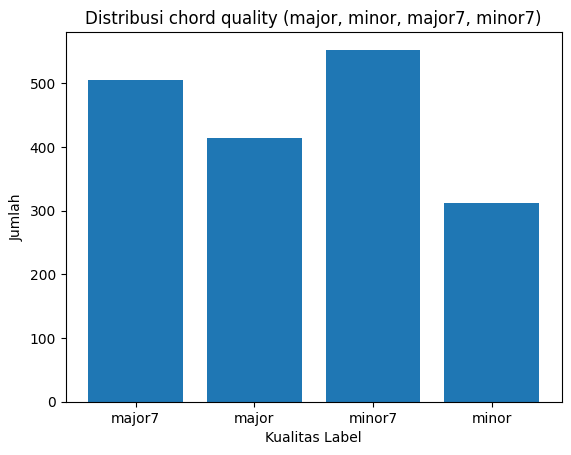

In [14]:
plt.title("Distribusi chord quality (major, minor, major7, minor7)")
plt.bar(label_quality_count.keys(),label_quality_count.values() )
plt.xlabel("Kualitas Label")
plt.ylabel("Jumlah")
plt.show()

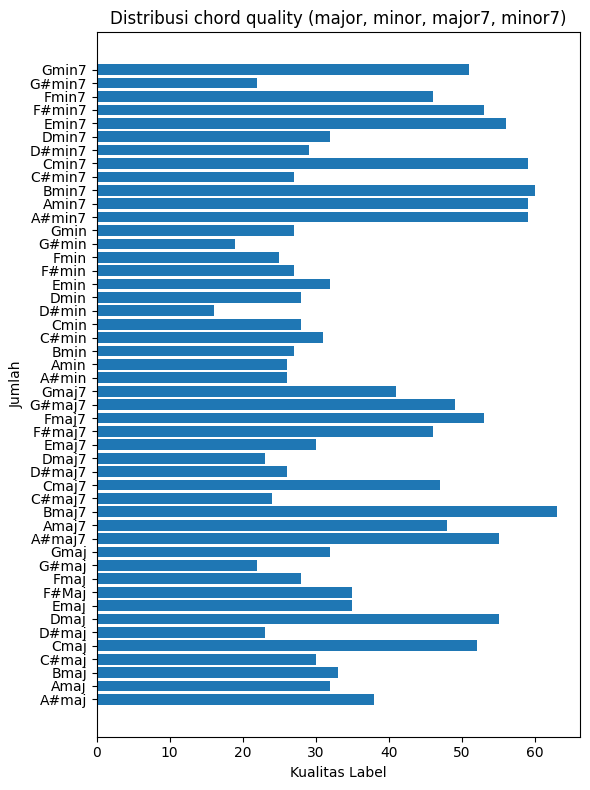

In [15]:
plt.figure(figsize=(6, 8))
plt.title("Distribusi chord quality (major, minor, major7, minor7)")
plt.barh(class_counts.keys(),class_counts.values() )
plt.xlabel("Kualitas Label")
plt.ylabel("Jumlah")
plt.tight_layout()
plt.show()

<h2> Turning audio to Mel Spectogram, reloading all the audio

In [10]:
import librosa
import numpy as np
import os

def extract_mel_spectrogram(file_path, sr=22050, duration=2.5, offset=0.5, n_mels=128, max_len=200):
    try:
        signal, _ = librosa.load(file_path, sr=sr, duration=duration, offset=offset)
        if len(signal) < 2048:  # or a suitable threshold
            stretch_factor = 2048 / len(signal) + 0.1  # stretch a bit more than the bare minimum
            signal = librosa.effects.time_stretch(signal, rate=1 / stretch_factor)
            print(f"Time-stretched {file_path} by factor {stretch_factor:.2f}")
        signal = signal / (np.sqrt(np.mean(signal**2)) + 1e-6)

        mel_spec = librosa.feature.melspectrogram(y=signal, sr=sr, n_mels=n_mels, n_fft=1024)
        mel_db = librosa.power_to_db(mel_spec, ref=np.max)  # Convert to dB scale

        if np.std(mel_db) == 0:
            print(f"Skipping {file_path}: mel spectrogram has zero std.")
            return None
        mel_db = (mel_db - np.mean(mel_db)) / np.std(mel_db)  # normalize
        # Pad or truncate to ensure consistent input shape
        if mel_db.shape[1] < max_len:
            pad_width = max_len - mel_db.shape[1]
            mel_db = np.pad(mel_db, ((0, 0), (0, pad_width)), mode='constant')
        else:
            mel_db = mel_db[:, :max_len]

        return mel_db
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None


def load_dataset_from_labeled_folders(dataset_path, sr=22050, duration=2.5, offset=0.5, n_mels=128):
    X = []
    y = []
    
    for chord_quality_dir in os.listdir(dataset_path):
        chord_quality_path = os.path.join(dataset_path, chord_quality_dir)
        if os.path.isdir(chord_quality_path):
            for chord_label_dir in os.listdir(chord_quality_path):
                chord_label_path = os.path.join(chord_quality_path, chord_label_dir)
                if os.path.isdir(chord_label_path):
                    for filename in os.listdir(chord_label_path):
                        if filename.endswith(".wav"):
                            file_path = os.path.join(chord_label_path, filename)
                            label = os.path.basename(chord_label_path)
                            try:
                                mel_feat = extract_mel_spectrogram(file_path, sr=sr, duration=duration, offset=offset, n_mels=n_mels)
                                if mel_feat is not None:
                                    X.append(mel_feat)
                                    y.append(label)
                            except Exception as e:
                                print(f"Failed to process {file_path}: {e}")

    return np.array(X), np.array(y)


In [11]:
X, y = load_dataset_from_labeled_folders(dataset_path)

# Encode guitar labels to numeric form
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_encoded = le.fit_transform(y)

#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)

#Adding new axis
X_train = X_train[..., np.newaxis]   # e.g., (samples, 128, 130, 1)
X_test = X_test[..., np.newaxis]

# One-hot encode
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

# Print stats
print(f"Loaded {len(X)} samples.")
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train_cat.shape)
print("Classes:", le.classes_)

/home/bryan_santosa/miniconda3/envs/machinelearning/lib/python3.10/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1390
  warnings.warn(


Time-stretched ./Farrel/Combined_dataset/MAJOR/Bmaj/strum_15.wav by factor 1.57


/home/bryan_santosa/miniconda3/envs/machinelearning/lib/python3.10/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=971
  warnings.warn(


Time-stretched ./Farrel/Combined_dataset/MAJOR 7/A#maj7/strum_38.wav by factor 2.21


/home/bryan_santosa/miniconda3/envs/machinelearning/lib/python3.10/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1169
  warnings.warn(


Time-stretched ./Farrel/Combined_dataset/MINOR/Dmin/strum_9.wav by factor 1.85


/home/bryan_santosa/miniconda3/envs/machinelearning/lib/python3.10/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1213
  warnings.warn(


Time-stretched ./Farrel/Combined_dataset/MINOR 7/Dmin7/strum_16.wav by factor 1.79


/home/bryan_santosa/miniconda3/envs/machinelearning/lib/python3.10/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1544
  warnings.warn(


Time-stretched ./Farrel/Combined_dataset/MINOR 7/Fmin7/strum_12.wav by factor 1.43
Loaded 1785 samples.
X_train shape: (1428, 128, 200, 1)
y_train shape: (1428, 48)
Classes: ['A#maj' 'A#maj7' 'A#min' 'A#min7' 'Amaj' 'Amaj7' 'Amin' 'Amin7' 'Bmaj'
 'Bmaj7' 'Bmin' 'Bmin7' 'C#maj' 'C#maj7' 'C#min' 'C#min7' 'Cmaj' 'Cmaj7'
 'Cmin' 'Cmin7' 'D#maj' 'D#maj7' 'D#min' 'D#min7' 'Dmaj' 'Dmaj7' 'Dmin'
 'Dmin7' 'Emaj' 'Emaj7' 'Emin' 'Emin7' 'F#Maj' 'F#maj7' 'F#min' 'F#min7'
 'Fmaj' 'Fmaj7' 'Fmin' 'Fmin7' 'G#maj' 'G#maj7' 'G#min' 'G#min7' 'Gmaj'
 'Gmaj7' 'Gmin' 'Gmin7']


In [14]:
# Shape of Output
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train_cat.shape)
print("y_test shape:", y_test_cat.shape)
num_classes = len(le.classes_)


X_train shape: (1428, 128, 200, 1)
X_test shape: (357, 128, 200, 1)
y_train shape: (1428, 48)
y_test shape: (357, 48)


<h2> Model Training

In [56]:
np.random.seed(42)
tensorflow.random.set_seed(42)

In [57]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout
from tensorflow.keras.layers import Reshape, Permute, Bidirectional, LSTM, Dense
from tensorflow.keras.optimizers import Adam

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(128, 200, 1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))   
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))   
model.add(Dropout(0.2))

model.add(Permute((2, 1, 3)))              
model.add(Reshape((50, 32 * 64)))          

model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.3))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])


In [58]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(patience=8, restore_best_weights=True)

history = model.fit(X_train, y_train_cat,
                    validation_split=0.2,
                    epochs=50,
                    batch_size=32,
                    callbacks=[early_stop],
                    verbose=1)

Epoch 1/50


2025-06-08 11:15:41.431461: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_5/dropout_20/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


36/36 [==============================] - 5s 55ms/step - loss: 3.8804 - accuracy: 0.0298 - val_loss: 3.8612 - val_accuracy: 0.0420
Epoch 2/50
36/36 [==============================] - 1s 41ms/step - loss: 3.8676 - accuracy: 0.0263 - val_loss: 3.8601 - val_accuracy: 0.0385
Epoch 3/50
36/36 [==============================] - 3s 89ms/step - loss: 3.8388 - accuracy: 0.0298 - val_loss: 3.8562 - val_accuracy: 0.0315
Epoch 4/50
36/36 [==============================] - 2s 42ms/step - loss: 3.8157 - accuracy: 0.0412 - val_loss: 3.8584 - val_accuracy: 0.0280
Epoch 5/50
36/36 [==============================] - 1s 41ms/step - loss: 3.8072 - accuracy: 0.0482 - val_loss: 3.8603 - val_accuracy: 0.0245
Epoch 6/50
36/36 [==============================] - 1s 41ms/step - loss: 3.7816 - accuracy: 0.0560 - val_loss: 3.8567 - val_accuracy: 0.0350
Epoch 7/50
36/36 [==============================] - 1s 41ms/step - loss: 3.7768 - accuracy: 0.0517 - val_loss: 3.8546 - val_accuracy: 0.0490
Epoch 8/50
36/36 [======

In [60]:
# Evaluate
loss, accuracy = model.evaluate(X_test, y_test_cat, verbose=0)
print(f'Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}')

Test Loss: 1.2300, Test Accuracy: 0.7283


<h3> Save models

In [61]:
model.save("guitar_chord_crnn_base_model.h5")
model.save("guitar_chord_crnn_base_.keras")

import pickle
with open("label_encoder.pkl", "wb") as f:
    pickle.dump(le, f)

/home/bryan_santosa/miniconda3/envs/machinelearning/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [45]:
pip install seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 11.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [seaborn]m3/4 [seaborn]
Note: you may need to restart the kernel to use updated packages.


<h3> Testing and Evaluation of Base Model

12/12 [==============================] - 1s 22ms/step - loss: 1.2300 - accuracy: 0.7283
Test Loss: 1.2300, Test Accuracy: 0.7283
12/12 [==============================] - 0s 9ms/step
Classification Report:
              precision    recall  f1-score   support

       A#maj       1.00      0.38      0.55         8
      A#maj7       0.55      1.00      0.71        11
       A#min       1.00      0.80      0.89         5
      A#min7       0.75      1.00      0.86        12
        Amaj       0.00      0.00      0.00         6
       Amaj7       0.59      1.00      0.74        10
        Amin       0.50      0.20      0.29         5
       Amin7       0.86      1.00      0.92        12
        Bmaj       0.80      0.57      0.67         7
       Bmaj7       0.54      1.00      0.70        13
        Bmin       1.00      0.40      0.57         5
       Bmin7       1.00      0.58      0.74        12
       C#maj       1.00      0.50      0.67         6
      C#maj7       1.00      0.80     

/home/bryan_santosa/miniconda3/envs/machinelearning/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/bryan_santosa/miniconda3/envs/machinelearning/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/bryan_santosa/miniconda3/envs/machinelearning/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

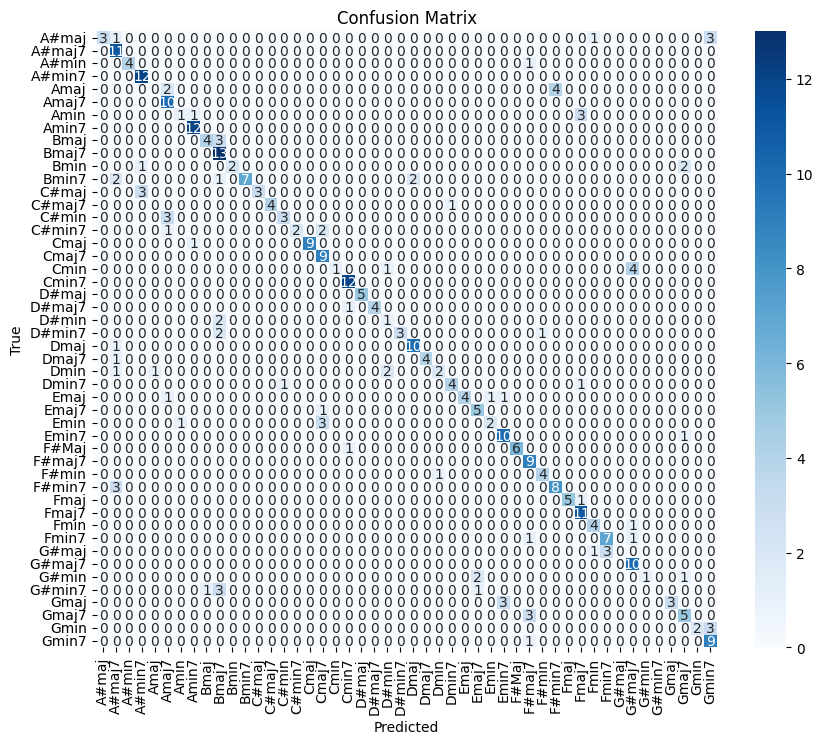

Macro Precision: 0.7552
Macro Recall: 0.6595
Macro F1-Score: 0.6623


/home/bryan_santosa/miniconda3/envs/machinelearning/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [62]:
model = load_model("./guitar_chord_crnn_base_model.h5")

loss, accuracy = model.evaluate(X_test, y_test_cat, verbose=1)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

from sklearn.metrics import classification_report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=le.classes_))


cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

precision_macro = precision_score(y_true, y_pred, average='macro')
recall_macro = recall_score(y_true, y_pred, average='macro')
f1_macro = f1_score(y_true, y_pred, average='macro')

# Print overall metrics (macro)
print(f"Macro Precision: {precision_macro:.4f}")
print(f"Macro Recall: {recall_macro:.4f}")
print(f"Macro F1-Score: {f1_macro:.4f}")


<h2> Hyperparameter Tuning

In [20]:
from keras_tuner import HyperModel
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout
from tensorflow.keras.layers import Reshape, Permute, Bidirectional, LSTM, Dense
from tensorflow.keras.optimizers import Adam

class CRNNHyperModel(HyperModel):
    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes

    def build(self, hp):
        model = Sequential()

        # Tune filters
        filters = hp.Choice('conv_filters', [32, 64])
        dropout_rate = hp.Choice('dropout_rate', [0.2, 0.3])
        lstm_units = hp.Choice('lstm_units', [32, 64])
        learning_rate = hp.Choice('learning_rate', [5e-4, 1e-4])

        model.add(Conv2D(filters, (3, 3), activation='relu', padding='same', input_shape=self.input_shape))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(dropout_rate))

        model.add(Conv2D(filters * 2, (3, 3), activation='relu', padding='same'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(dropout_rate))

        model.add(Permute((2, 1, 3)))
        model.add(Reshape((50, -1)))  # time steps = 32

        model.add(Bidirectional(LSTM(lstm_units)))
        model.add(Dropout(dropout_rate))

        model.add(Dense(64, activation='relu'))
        model.add(Dropout(dropout_rate))
        model.add(Dense(self.num_classes, activation='softmax'))

        model.compile(optimizer=Adam(learning_rate=learning_rate),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
        return model


In [68]:
from keras_tuner.tuners import RandomSearch

expanded_tuning = RandomSearch(
    CRNNHyperModel(input_shape=(128, 200, 1), num_classes = num_classes),
    objective='val_accuracy',
    max_trials=15,
    executions_per_trial=1,
    directory='crnn_tuning(3)',
    project_name='chord_recognition'
)

expanded_tuning.search(X_train, y_train_cat, epochs=50, validation_split=0.2, batch_size=32)


Reloading Tuner from crnn_tuning(3)/chord_recognition/tuner0.json


In [69]:
best_hps = expanded_tuning.get_best_hyperparameters(num_trials=1)[0]

# Print all chosen hyperparameters
print("Best hyperparameters:")
print(f"Learning rate: {best_hps.get('learning_rate')}")
print(f"Dropout rate: {best_hps.get('dropout_rate')}")
print(f"LSTM units: {best_hps.get('lstm_units')}")
print(f"Conv filters: {best_hps.get('conv_filters')}")

Best hyperparameters:
Learning rate: 0.0005
Dropout rate: 0.2
LSTM units: 64
Conv filters: 32


In [70]:
model = expanded_tuning.hypermodel.build(best_hps)

In [71]:
early_stop = EarlyStopping(patience=8, restore_best_weights=True)

history = model.fit(X_train, y_train_cat,
                    validation_split=0.2,
                    epochs=60,
                    batch_size=32,
                    callbacks=[early_stop],
                    verbose=1)

Epoch 1/60


2025-06-08 11:23:39.240503: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_6/dropout_24/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


36/36 [==============================] - 6s 102ms/step - loss: 3.9056 - accuracy: 0.0289 - val_loss: 3.8692 - val_accuracy: 0.0524
Epoch 2/60
36/36 [==============================] - 1s 40ms/step - loss: 3.8475 - accuracy: 0.0306 - val_loss: 3.8639 - val_accuracy: 0.0210
Epoch 3/60
36/36 [==============================] - 1s 40ms/step - loss: 3.8346 - accuracy: 0.0342 - val_loss: 3.8649 - val_accuracy: 0.0175
Epoch 4/60
36/36 [==============================] - 1s 40ms/step - loss: 3.7850 - accuracy: 0.0552 - val_loss: 3.8742 - val_accuracy: 0.0140
Epoch 5/60
36/36 [==============================] - 1s 40ms/step - loss: 3.6920 - accuracy: 0.0911 - val_loss: 3.8745 - val_accuracy: 0.0210
Epoch 6/60
36/36 [==============================] - 1s 40ms/step - loss: 3.5677 - accuracy: 0.1208 - val_loss: 3.8784 - val_accuracy: 0.0455
Epoch 7/60
36/36 [==============================] - 1s 40ms/step - loss: 3.4272 - accuracy: 0.1471 - val_loss: 3.8635 - val_accuracy: 0.0664
Epoch 8/60
36/36 [=====

In [72]:
# Evaluate
loss, accuracy = model.evaluate(X_test, y_test_cat, verbose=0)
print(f'Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}')

Test Loss: 0.2162, Test Accuracy: 0.9524


In [65]:
a = 94.68
b = 72.83
x = (a - b)/ b
print(x)

0.30001373060551983


In [30]:
model.save("guitar_chord_crnn_tuned_model.h5")
model.save("guitar_chord_crnn_tuned_.keras")

import pickle
with open("label_encoder_tuned.pkl", "wb") as f:
    pickle.dump(le, f)

/home/bryan_santosa/miniconda3/envs/machinelearning/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


<h2> Evalution of Hyper parameter modelling

12/12 [==============================] - 1s 18ms/step - loss: 1.2300 - accuracy: 0.7283
Test Loss: 1.2300, Test Accuracy: 0.7283
12/12 [==============================] - 1s 10ms/step
Classification Report:
              precision    recall  f1-score   support

       A#maj       1.00      0.38      0.55         8
      A#maj7       0.55      1.00      0.71        11
       A#min       1.00      0.80      0.89         5
      A#min7       0.75      1.00      0.86        12
        Amaj       0.00      0.00      0.00         6
       Amaj7       0.59      1.00      0.74        10
        Amin       0.50      0.20      0.29         5
       Amin7       0.86      1.00      0.92        12
        Bmaj       0.80      0.57      0.67         7
       Bmaj7       0.54      1.00      0.70        13
        Bmin       1.00      0.40      0.57         5
       Bmin7       1.00      0.58      0.74        12
       C#maj       1.00      0.50      0.67         6
      C#maj7       1.00      0.80    

/home/bryan_santosa/miniconda3/envs/machinelearning/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/bryan_santosa/miniconda3/envs/machinelearning/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/bryan_santosa/miniconda3/envs/machinelearning/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

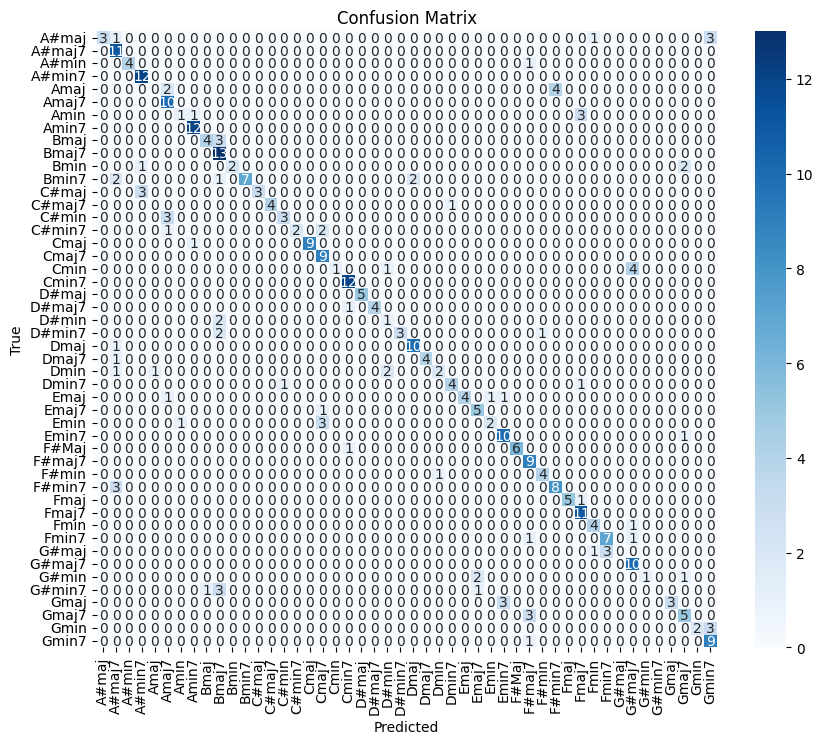

In [67]:
# 1. Load the saved model
model = load_model("./guitar_chord_crnn_tuned_model_random_state.h5")

# 2. Evaluate on the test set
loss, accuracy = model.evaluate(X_test, y_test_cat, verbose=1)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

# 3. Get predictions
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

# 4. Print classification report
from sklearn.metrics import classification_report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=le.classes_))

# 5. (Optional) Show confusion matrix

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
precision_macro = precision_score(y_true, y_pred, average='macro')
recall_macro = recall_score(y_true, y_pred, average='macro')
f1_macro = f1_score(y_true, y_pred, average='macro')

# Print overall metrics (macro)
print(f"Macro Precision: {precision_macro:.4f}")
print(f"Macro Recall: {recall_macro:.4f}")
print(f"Macro F1-Score: {f1_macro:.4f}")

Macro Precision: 0.9585
Macro Recall: 0.9523
Macro F1-Score: 0.9521
